We plot the phase portraits for the different stimulus conditions. 

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from perturbed_organics.spectrum_general import sim_solution
import perturbed_organics.model.ORGaNICs_models as organics
import perturbed_organics.utils as utils
import matplotlib.ticker as ticker
import os


# Set default dtype for torch
torch.set_default_dtype(torch.float64)

In [2]:
# Define simulation parameters
N = 100
params = {"N_y": N, "N_a": N, "eta": 0.02, "noise_type": "additive"}
b0 = torch.ones(N)
b1 = torch.ones(N)
sigma = torch.tensor([0.1])
tauA = 0.002 + 0 * torch.abs(torch.randn(N) * 0.001)
tauY = 0.002 + 0 * torch.abs(torch.randn(N) * 0.001)
# Wyy = torch.eye(N)
Way = torch.ones(N, N)

In [3]:
# Helper: compute when a neuron's changes become consistently small
def find_convergence_time(neuron_traj, t_chunk, epsilon=1e-4, window=20):
    diffs = torch.abs(neuron_traj[1:] - neuron_traj[:-1])
    for i in range(len(diffs) - window + 1):
        if torch.all(diffs[i:i+window] < epsilon):
            return t_chunk[i]
    return t_chunk[-1]  # if never converged, assign final time

# Helper: for each neuron, compute convergence time and pick the one with the maximum time
def find_slowest_neuron(traj, t_chunk, epsilon=1e-4, window=20):
    conv_times = [find_convergence_time(traj[:, i], t_chunk, epsilon, window) for i in range(N)]
    # return both the max time and the index of the neuron
    max_time = max(conv_times)
    max_index = conv_times.index(max_time)
    return max_time, max_index

In [16]:
# Specify delta and generate Wyy
mu = 0.0

# Model setup
delta_phase = {
    'stable': 0.05,
    'critically_slowed_down': 0.3,
    'limit_cycle': 1.0,
    'unstable': 3.0
}

input_norm = 0.05
# phase_region = 'stable'
# phase_region = 'critically_slowed_down'
phase_region = 'limit_cycle'
# phase_region = 'unstable'
delta = delta_phase[phase_region]


model_name = 'delocalized'
z = utils.make_input_drive(N=N, input_type=model_name, input_norm=input_norm)
# initial_type = 'norm'
initial_type = 'zero'

# Define the time vector for simulation
tau_min = min(torch.min(tauA), torch.min(tauY))
tau_max = max(torch.max(tauA), torch.max(tauY))
chunk_time = 1000 * tau_max
dt = 0.05 * tau_min
points = int(chunk_time / dt)
t_chunk = torch.linspace(0, chunk_time, points)

# sample the recurrent weight matrix
Wyy = torch.eye(N) + utils.generate_matrix(N=N, matrix_type='goe_symmetric', s=N, mu=mu, delta=delta)

# define the model
model = organics.ORGaNICs2Dgeneral(
        params=params,
        b0=b0,
        b1=b1,
        sigma=sigma,
        tauA=tauA,
        tauY=tauY,
        Wyy=Wyy,
        Way=Way,
        z=z,
        initial_type=initial_type,
        run_jacobian=False,
    )

y0 = model.inital_conditions(initial_type=initial_type)

sim_obj = sim_solution(model)

traj = sim_obj.simulate(t_chunk, y0=y0)

# find the slowest neuron
slowest_time, slow_idx = find_slowest_neuron(traj, t_chunk, epsilon=1e-5, window=100)

# define the index to plot the phase portrait for
idx_y = slow_idx
idx_a = N + idx_y


# Extract the simulation data for neurons 0 and 1
sim_neuron0 = traj[:, idx_y].detach().numpy()
sim_neuron1 = traj[:, idx_a].detach().numpy()

In [17]:
# find the final limit cycle
if phase_region == 'limit_cycle':
    final_cycle = traj[-int(points*0.01):, :].detach().numpy()

In [18]:
final_cycle.shape

(200, 200)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


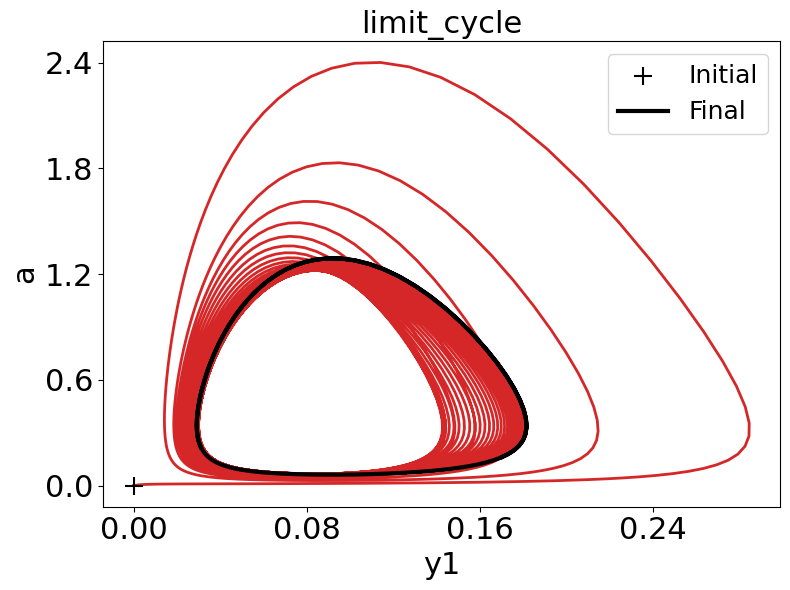

In [19]:
plt.figure(figsize=(8, 6)) # You might want to increase figsize slightly too, e.g., (10, 8)

# Plot with increased line width
plt.plot(sim_neuron0, sim_neuron1, color='#d62728', linewidth=2.0, zorder=0)

# Initial point marker
plt.scatter(sim_neuron0[0], sim_neuron1[0],
            color='green', s=150, marker='+', facecolors='black', label='Initial', zorder=1)

# Final point marker
if phase_region == 'limit_cycle':
    plt.plot(final_cycle[:, idx_y], final_cycle[:, idx_a], color='black', linewidth=3.0, label=f'Final', zorder=1)
else:
    plt.scatter(sim_neuron0[-1], sim_neuron1[-1],
            color='red', s=60, marker='o', facecolors='black', edgecolors='black',  label=f'Final', zorder=1)

# Apply the increased font size to labels and title
plt.xlabel('y1', fontsize=22)
plt.ylabel('a', fontsize=22)
plt.title(phase_region, fontsize=22)

# Apply the increased font size to tick labels
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

# Optional: Add grid lines if desired (can sometimes help readability)
# plt.grid(True, linestyle='--', alpha=0.6)

# Optional: Adjust tick locator for clarity like in your example
# import matplotlib.ticker as ticker
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))

plt.legend(fontsize=18, loc='best')

# Use tight_layout to adjust plot parameters for a tight layout
plt.tight_layout()

folder_loc = f'../figures/mu_{mu}/fig_phase_portraits/'
os.makedirs(folder_loc, exist_ok=True)
file_name = f"{phase_region}_delta_{delta}_input_{input_norm}"
file_save_path = os.path.join(folder_loc, file_name)

plt.savefig(f'{file_save_path}.png', bbox_inches='tight')
plt.savefig(f'{file_save_path}.svg', format='svg', bbox_inches='tight', dpi=300)
plt.savefig(f'{file_save_path}.eps', format='eps', bbox_inches='tight', dpi=300)

# Show the plot
plt.show()